# Learning motion with constant velocity (pure RNN)
In this experiment, we are trying to construct a recurrent model that is able to predict the future positions of particle given first two positions. The ground truth is that particle moves with constant speed. We expect that the model will be able to learn the velocity and law of motion.

The input is first two timesteps, the rest of input is zeros.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [55]:
def get_data(num_samples, timesteps, vnorm=0.01, x0=None, phi0=None):
    """
    Returns data that is needed to train the model
    num_samples is the number of samples
    timesteps is number of timesteps to generate
    vnorm is a velocity norm
    x0 is a start position
    phi0 is an angle
    
    returns 
        input_data (first two positions kept, the rest is zeroed), 
        target_data (all the trajectory, starting with t=1)
    """
    x0 = (np.random.uniform(0.33, 0.66, size=(num_samples, 2)) 
          if x0 is None else x0)
    phi0 = (np.random.uniform(0, 2 * np.pi, size=(num_samples)) 
            if phi0 is None else phi0)
    v = np.stack([np.cos(phi0), np.sin(phi0)], axis=1) * vnorm
    t = np.arange(timesteps + 1)
        
    trajectories = x0[:, np.newaxis, :] + np.einsum('t,sc->stc', t, v)
    # motion with constant speed
    
    input_data = trajectories.copy()[:, :-1, :]
    input_data[:, 2:, :] = 0
    target_data = trajectories[:, 1:, :]
    return input_data, target_data

In [56]:
num_samples = 50000
timesteps = 10
input_data, target_data = get_data(num_samples, timesteps)

In [57]:
input_data.shape

(50000, 10, 2)

In [58]:
target_data.shape

(50000, 10, 2)

In [59]:
from keras.models import Model, Sequential
from keras.layers import Input, SimpleRNNCell, SimpleRNN, GRU, Dense, Flatten
from keras import backend as K

Let us look at the generated data

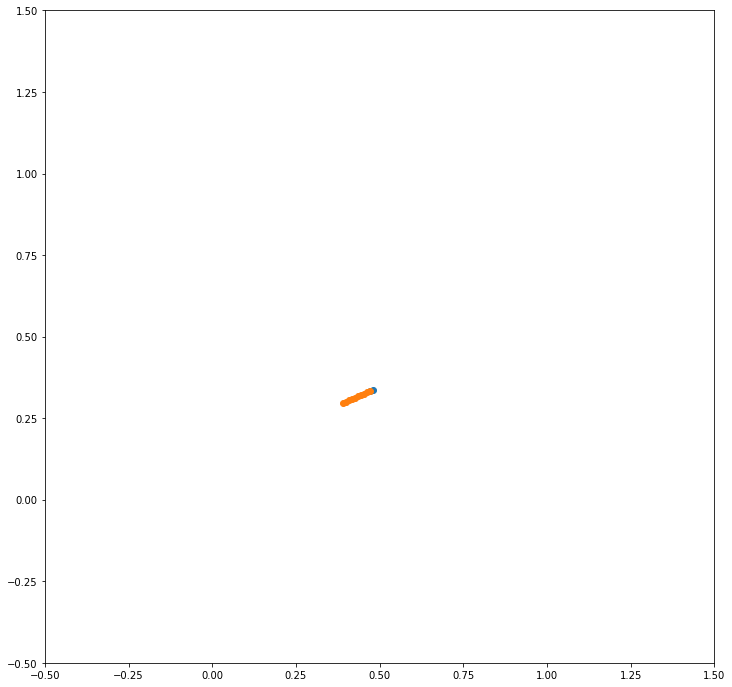

In [70]:
# One random sample
fig = plt.figure(figsize=(12, 12))
sample = np.random.randint(len(input_data))
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.plot(input_data[sample][:2, 0], input_data[sample][:2, 1], 'o')
plt.plot(target_data[sample][:, 0], target_data[sample][:, 1], 'o')

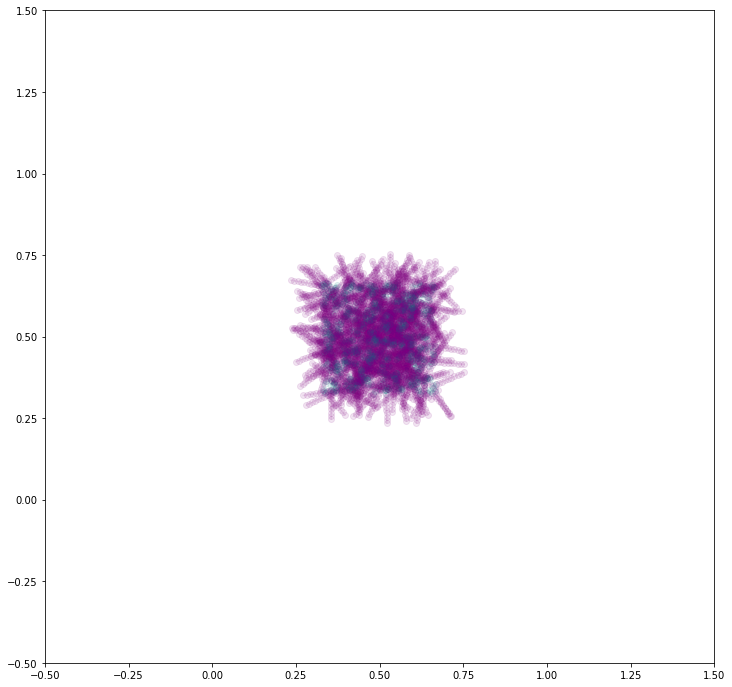

In [71]:
# Several samples
fig = plt.figure(figsize=(12, 12))
for _ in range(500):
    sample = np.random.randint(len(input_data))
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.plot(input_data[sample][:2, 0], input_data[sample][:2, 1], '-o', 
             color='teal', alpha=0.1)
    plt.plot(target_data[sample][:, 0], target_data[sample][:, 1], '-o', 
             color='purple', alpha=0.1)

In [62]:
epochs = 100
latent_dim = 16
batch_size = 64

print('Number of samples:', len(input_data))
print('Sequence length for outputs:', target_data.shape[1])

# Define an input sequence and process it.
inputs = Input(shape=(None,) + input_data.shape[2:])

recurrent = GRU(latent_dim, return_sequences=True, return_state=True)
recurrent_dense = Dense(target_data.shape[2])

recurrent_outputs, _= recurrent(inputs)
recurrent_outputs = recurrent_dense(recurrent_outputs)

model = Model(inputs, recurrent_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='mse')

model.fit(input_data, target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('learning_motion_pure.h5')

Number of samples: 50000
Sequence length for outputs: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 8s 208us/step - loss: 0.0153 - val_loss: 0.0025
Epoch 2/100
40000/40000 [==============================] - 8s 189us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/100
40000/40000 [==============================] - 7s 184us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/100
40000/40000 [==============================] - 7s 180us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
40000/40000 [==============================] - 8s 188us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/100
40000/40000 [==============================] - 9s 229us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/100
40000/40000 [==============================] - 7s 174us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/100
40000/40000 [==============================] - 7s 172us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/100
40000/40000 [============

Epoch 72/100
40000/40000 [==============================] - 7s 172us/step - loss: 2.7000e-04 - val_loss: 2.5036e-04
Epoch 73/100
40000/40000 [==============================] - 7s 167us/step - loss: 2.6404e-04 - val_loss: 3.3928e-04
Epoch 74/100
40000/40000 [==============================] - 7s 173us/step - loss: 2.5624e-04 - val_loss: 2.7185e-04
Epoch 75/100
40000/40000 [==============================] - 7s 173us/step - loss: 2.4654e-04 - val_loss: 2.9651e-04
Epoch 76/100
40000/40000 [==============================] - 7s 168us/step - loss: 2.3962e-04 - val_loss: 1.3761e-04
Epoch 77/100
40000/40000 [==============================] - 7s 181us/step - loss: 2.3202e-04 - val_loss: 1.9702e-04
Epoch 78/100
40000/40000 [==============================] - 7s 166us/step - loss: 2.2744e-04 - val_loss: 1.9192e-04
Epoch 79/100
40000/40000 [==============================] - 7s 173us/step - loss: 2.2097e-04 - val_loss: 1.2023e-04
Epoch 80/100
40000/40000 [==============================] - 7s 186us/ste

In [65]:
def plot_traj(traj, mode='-', ax=None, label=None):
    tr = traj.reshape(-1, 1, 2)
    for i in range(1):
        if ax is None:
            plt.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)
        else:
            ax.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)

Now we generate testing data. During test, we will consider starting position at $(0.5, 0.5)$ and different velocity vectors. For each velocity vector, we generate twice as long input and draw two segements of predictions: prediction with the number of timesteps that was used in training, and the extended predictions. The latter should demonstrate, how well our model generalizes, or, in other words, how well the law of motion was learned.

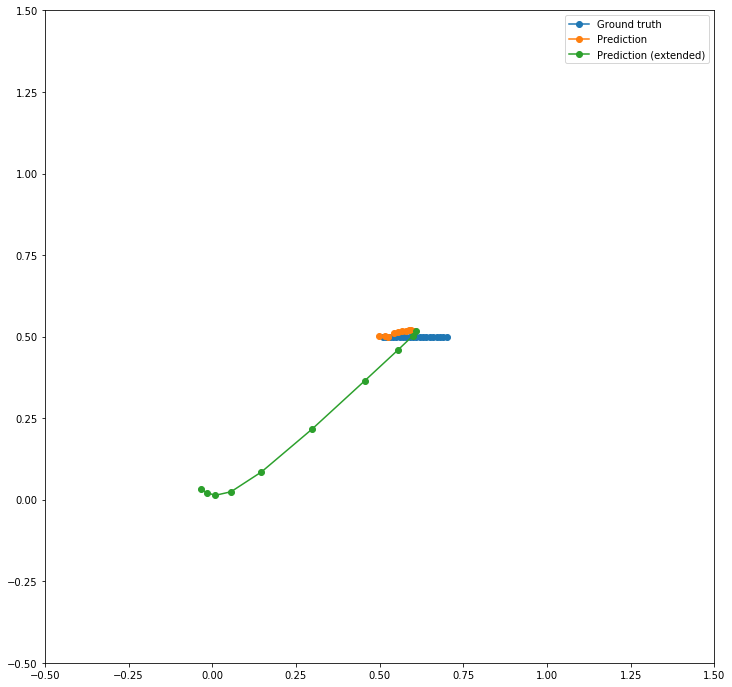

In [66]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
def draw(theta, ax):
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    test_input_data, test_target_data = get_data(
        1, timesteps * 2, x0=np.array([[0.5, 0.5]]), phi0 = np.array([theta]))
    prediction = model.predict(test_input_data)
#    plot_traj(test_input_data[0], mode='o-', label="Initial position", ax=ax)
    plot_traj(test_target_data[0], mode='o-', label='Ground truth', ax=ax)
    plot_traj(prediction[0, :timesteps], mode='o-', label='Prediction', ax=ax)
    plot_traj(prediction[0, timesteps:], mode='o-', label='Prediction (extended)', 
               ax=ax)
    plt.legend()
draw(0, ax)

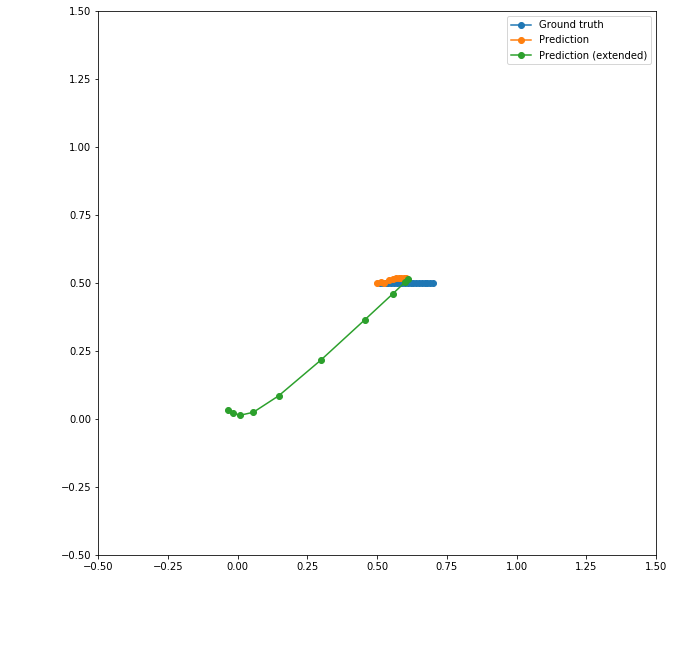

In [67]:
import matplotlib.animation as animation
from IPython.display import HTML

def show_ani():
    """
    Shows an animation of trajectories for rotating angle
    """
    def ani_frame():
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        draw(0, ax)

        def update_img(n):
            ax.clear()
            draw(n/10, ax=ax)
            return ax

        ani = animation.FuncAnimation(fig, update_img, 100,
                                      interval=100)
        return ani

    ani = ani_frame()
    return HTML(ani.to_html5_video())
show_ani()